In [1]:
# !pip install protobuf==3.20.1

In [62]:
# from sagemaker.xgboost.estimator import XGBoost
import xgboost as xgb
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from tqdm import tqdm
import os
import xlsxwriter
from openpyxl.utils.dataframe import dataframe_to_rows
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report

### data + dates

In [3]:
df = pd.read_parquet('s3://sisyphus-general-bucket/AthenaInsights/latest_data/model/data/stock_bars_1min.parquet' )

In [4]:
category_map = {'A': 0, 'B': 1, 'C':2}
reverse_category_map = {v: k for k, v in category_map.items()}

In [5]:
df = df.fillna(0)
df['mapped_category'] = df['category'].map({'A': 0, 'B': 1, 'C':2})
df['mapped_category'].value_counts()

mapped_category
2    192523
0     12361
1      9910
Name: count, dtype: int64

In [35]:
df.tail()

,open,high,low,close,volume,time_delta,open_ema_2m,open_sma_2m,high_ema_2m,high_sma_2m,...,local_max_30,local_min_30,cumulative_local_max_30,cumulative_local_min_30,time_since_prev_max_30,time_since_prev_min_30,category,no change,up,mapped_category
us_eastern_timestamp,,,,,,,,,,,,,,,,,,,,,
2024-11-19 19:55:00,591.53,591.53,591.50,591.52,1052.0,0.0,591.542039,591.530,591.542121,591.530,...,False,False,27193,23140,6,16,C,1,0,2
2024-11-19 19:56:00,591.52,591.54,591.48,591.48,3823.0,0.0,591.527346,591.525,591.540707,591.535,...,False,False,27193,23140,7,17,C,0,0,2
2024-11-19 19:57:00,591.46,591.46,591.41,591.42,3656.0,0.0,591.482449,591.490,591.486902,591.500,...,False,False,27193,23140,8,18,C,0,0,2
2024-11-19 19:58:00,591.40,591.40,591.35,591.39,1354.0,0.0,591.427483,591.430,591.428967,591.430,...,False,False,27193,23140,9,19,C,0,0,2
2024-11-19 19:59:00,591.39,591.40,591.35,591.39,2567.0,0.0,591.402494,591.395,591.409656,591.400,...,False,False,27193,23140,10,20,C,1,0,2


### train test split

In [63]:
from datetime import datetime, timedelta

In [64]:
start_date = '2024-11-01'
end_date = '2024-11-19' # datetime.today().strftime('%Y-%m-%d')
date_series = pd.date_range(start=start_date, end=end_date, freq='D')
date_series = [z.strftime('%Y-%m-%d') for z in date_series]
print(date_series)

['2024-11-01', '2024-11-02', '2024-11-03', '2024-11-04', '2024-11-05', '2024-11-06', '2024-11-07', '2024-11-08', '2024-11-09', '2024-11-10', '2024-11-11', '2024-11-12', '2024-11-13', '2024-11-14', '2024-11-15', '2024-11-16', '2024-11-17', '2024-11-18', '2024-11-19']


In [65]:
date_series[0]

'2024-11-01'

In [66]:
# Create a DataFrame with initial content
file_name = "results/results_0.xlsx"

# if os.path.exists(file_name):
#     file_name, result_num = file_name.split(".")[0].split("_")
#     result_num += 1
#     file_name = file_name + result_num + ".xlsx"
#     print(f'base name: {file_name}')

data = {'features used': list(df.columns)}
data = pd.DataFrame(data)

sheet_name = 'InitialSheet'

# Write the DataFrame to an Excel file with a custom sheet name
with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
    data.to_excel(writer, sheet_name=sheet_name, index=False)

In [67]:
def get_dates(dt):
    test_date = dt
    next_day = (datetime.strptime(test_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
    next_10_day = (datetime.strptime(test_date, '%Y-%m-%d') + timedelta(days=9)).strftime('%Y-%m-%d')
    prev_day = (datetime.strptime(test_date, '%Y-%m-%d') + timedelta(days=-1)).strftime('%Y-%m-%d')
    return test_date, next_day, next_10_day, prev_day

In [68]:
def get_train_test_split(dt):

    X_train = df.loc[:prev_day, ].drop(columns=['category', 'mapped_category'])
    y_train = df.loc[:prev_day, 'mapped_category']

    X_test = df.loc[test_date: next_10_day, ].drop(columns=['category', 'mapped_category'])
    y_test = df.loc[test_date: next_10_day, 'mapped_category']

    X_test_full = df.loc[test_date:, ].drop(columns=['category', 'mapped_category'])
    y_test_full = df.loc[test_date:, 'mapped_category']

    X_test_only_next_day = df.loc[test_date, ].drop(columns=['category', 'mapped_category'])
    y_test_only_next_day = df.loc[test_date, 'mapped_category']
    
    return X_train, y_train, X_test, y_test, X_test_full, y_test_full, X_test_only_next_day, y_test_only_next_day

In [69]:
from openpyxl.drawing.image import Image



In [70]:
def log(x, dt, image=None, add=None):
    if type(x)==type('str') or type(x).__name__=='DataFrame':
        if type(x)==type('str'):
            data = {'text': [x]}
            data = pd.DataFrame(data)
        else:
            data = x

        book = openpyxl.load_workbook(file_name)
        if dt in book.sheetnames:
            sheet = book[dt]
            start_row = sheet.max_row + 1  # Find the first empty row
            
        else:
            sheet = book.create_sheet(dt)  # Create a new sheet
            start_row = 1

         # Convert DataFrame to rows and append to the sheet
        for r_idx, row in enumerate(dataframe_to_rows(data, index=False, header=False), start=start_row):
            for c_idx, value in enumerate(row, start=1):
                sheet.cell(row=r_idx, column=c_idx, value=value)

        book.save(file_name)

    elif image==1:
        book = openpyxl.load_workbook(file_name)
        sheet = book[dt]
        img = Image(add)
        sheet.add_image(img)
        book.save(file_name)
    else:
        raise ValueError('what are you trying to save?')

In [71]:
def initialte_and_train(X_train, y_train, X_test, y_test, X_test_full, y_test_full, X_test_only_next_day, y_test_only_next_day):
    
    clf = xgb.XGBClassifier(n_estimators=100,
                            objective='multi:softmax',
                            n_jobs =-1,
                            random_state=420,
                            num_class=3,
                            eval_metric=['merror','mlogloss'])
    clf.fit(X_train,
            y_train,
            verbose=0,
            eval_set=[(X_train, y_train), (X_test, y_test), (X_test_full, y_test_full), (X_test_only_next_day, y_test_only_next_day)])
    
    return clf

In [72]:
def get_results(clf, dt):
    results = clf.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)

    log(f"results: {results}", dt)
    log(f"epochs: {epochs}", dt)
    log("\n\n", dt)

    # xgboost 'mlogloss' plot
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
    ax.plot(x_axis, results['validation_2']['mlogloss'], label='Test_full')
    ax.plot(x_axis, results['validation_3']['mlogloss'], label='Test_only_next_day')
    ax.legend()
    plt.ylabel('mlogloss')
    plt.title(f'GridSearchCV XGBoost mlogloss - {dt}')
    # plt.show()
    fig.savefig(f'results/images/GridSearchCV XGBoost mlogloss - {dt}.png')
    log(None, dt, image=1, add=f'results/images/GridSearchCV XGBoost mlogloss - {dt}.png')
    log("\n\n", dt)

    # xgboost 'merror' plot
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(x_axis, results['validation_0']['merror'], label='Train')
    ax.plot(x_axis, results['validation_1']['merror'], label='Test')
    ax.plot(x_axis, results['validation_2']['merror'], label='Test_full')
    ax.plot(x_axis, results['validation_3']['merror'], label='Test_only_next_day')
    ax.legend()
    plt.ylabel('merror')
    plt.title(f'GridSearchCV XGBoost merror - {dt}')
    # plt.show()
    fig.savefig(f'results/images/GridSearchCV XGBoost merror - {dt}.png')
    log(None, dt, image=1, add=f'results/images/GridSearchCV XGBoost merror - {dt}.png')
    log("\n\n", dt)

In [73]:
def generate_reports(x, y, clf, next_day=False):
    log('## ---------- Model Classification Report ----------', dt)
    log('## get predictions and create model quality report', dt)

    y_p = clf.predict(x)

    log('\n------------------ Confusion Matrix -----------------\n', dt)
    log(pd.DataFrame(confusion_matrix(y, y_p)), dt)

    if next_day:
        preds_probs = clf.predict_proba(x)
        for i in range(4, 10, 1):
            log(f'threshold - {i/10}', dt)
            preds_probs1 = (preds_probs>=i/10).argmax(axis=1,)
            log(pd.DataFrame(confusion_matrix(y, preds_probs1)), dt)
            log('\n\n', dt)

    log('\n-------------------- Key Metrics --------------------', dt)
    log('\nAccuracy: {:.2f}'.format(accuracy_score(y, y_p)), dt)
    log('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y, y_p)), dt)

    log('Micro Precision: {:.2f}'.format(precision_score(y, y_p, average='micro')), dt)
    log('Micro Recall: {:.2f}'.format(recall_score(y, y_p, average='micro')), dt)
    log('Micro F1-score: {:.2f}\n'.format(f1_score(y, y_p, average='micro')), dt)

    log('Macro Precision: {:.2f}'.format(precision_score(y, y_p, average='macro')), dt)
    log('Macro Recall: {:.2f}'.format(recall_score(y, y_p, average='macro')), dt)
    log('Macro F1-score: {:.2f}\n'.format(f1_score(y, y_p, average='macro')), dt)

    log('Weighted Precision: {:.2f}'.format(precision_score(y, y_p, average='weighted')), dt)
    log('Weighted Recall: {:.2f}'.format(recall_score(y, y_p, average='weighted')), dt)
    log('Weighted F1-score: {:.2f}'.format(f1_score(y, y_p, average='weighted')), dt)

    log('\n--------------- Classification Report ---------------\n', dt)
    log(classification_report(y, y_p), dt)
    log('---------------------- XGBoost ----------------------', dt) # unnecessary fancy styling

In [74]:
def plot_categorization(df, date, pred, field='close', ):
    """ Plot categorization for a given day with dynamic field selection """
    df_day = df.loc[date]
    df_day['preds'] = list(pred)
    # categories, future_highs, future_lows = categorize_points(df_day, field=field, **kwargs)
    # df_day['category'] = categories
    # df_day['future_highs'] = future_highs
    # df_day['future_lows'] = future_lows

    
    plt.figure(figsize=(14, 7))
    plt.plot(df_day.index, df_day[field], label=f'{field.capitalize()} Price', color='gray', linewidth=2)
    # plt.plot(df_day.index, df_day['close'], label=f'{field.capitalize()} Price', color='blue', linewidth=1)
    for cat, color in zip(['A', 'B', 'C'], ['green', 'red', 'gray']):
        plt.scatter(df_day[df_day['category'] == cat].index, df_day[df_day['category'] == cat][field], color=color, label=f'Category {cat}', s=30 if cat!='C' else 0)
    for cat, color in zip(['A', 'B', 'C'], ['blue', 'black', 'pink']):
        # print(cat)
        # print(df_day[df_day['preds'] == cat].index)
        plt.scatter(df_day[df_day['preds'] == cat].index, df_day[df_day['preds'] == cat][field], color=color, label=f'Preds {cat}', s=20 if cat!='C' else 10, 
                    # marker = '1' if cat=='B' else '2' if cat=='A' else '+')
                    marker='s')
    plt.legend()
    plt.title(f'Price Categorization on {date}')
    plt.xlabel('Timestamp')
    plt.ylabel(f'{field.capitalize()} Price')
    # plt.show()
    plt.savefig(f'results/images/plot for day - {date}.png')
    log(None, dt, image=1, add=f'results/images/plot for day - {date}.png')
    log("\n\n", date)

In [ ]:
for dt in tqdm(date_series):
    print(f"running for dt = {dt}", dt)
    log(f"running for dt = {dt}", dt)
    log ("\n\n", dt)
    test_date, next_day, next_10_day, prev_day = get_dates(dt)

    log(f"test_date: {test_date}, next_day: {next_day}, next_10_day: {next_10_day}, prev_day: {prev_day}", dt)
    log("\n", dt)

    X_train, y_train, X_test, y_test, X_test_full, y_test_full, X_test_only_next_day, y_test_only_next_day = get_train_test_split(df)

    log(f"y_train.value_counts():\n{y_train.value_counts()}", dt)
    log(f"y_test.value_counts():\n{y_test.value_counts()}", dt)
    log(f"y_test_full.value_counts():\n{y_test_full.value_counts()}", dt)
    log(f"y_test_only_next_day.value_counts():\n{y_test_only_next_day.value_counts()}", dt)
    log("\n\n", dt)

    log("training the model", dt)
    clf = initialte_and_train(X_train, y_train, X_test, y_test, X_test_full, y_test_full, X_test_only_next_day, y_test_only_next_day)
    log("\n\n", dt)

    log("results", dt)
    get_results(clf, dt)
    log("\n\n", dt)

    log("reports", dt)

    if not X_test.empty:
        log("10 day test", dt)
        generate_reports(X_test, y_test, clf)
        log("\n\n", dt)

    if not X_test_full.empty:
        log("full day test", dt)
        generate_reports(X_test_full, y_test_full, clf)
        log("\n\n", dt)

    if not X_test_only_next_day.empty:
        log("1 day test", dt)
        generate_reports(X_test_only_next_day, y_test_only_next_day, clf, next_day=True)
        log("\n\n", dt)

    feature_important = clf.feature_importances_ 
    keys = list(X_train.columns)
    values = list(feature_important)

    log("feature importances", dt)
    fea_imp = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
    log(fea_imp, dt)

    if not X_test_only_next_day.empty:
        preds_probs = clf.predict_proba(X_test_only_next_day)
        preds_probs1 = (preds_probs >= 0.5).argmax(axis=1,)
        plot_categorization(df, dt, pd.Series(preds_probs1).map(reverse_category_map))

  0%|          | 0/19 [00:00<?, ?it/s]

running for dt = 2024-11-01 2024-11-01


/home/ec2-user/anaconda3/envs/fools_gold/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/fools_gold/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/fools_gold/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

running for dt = 2024-11-02 2024-11-02


 11%|█         | 2/19 [02:35<21:51, 77.16s/it]

running for dt = 2024-11-03 2024-11-03


 16%|█▌        | 3/19 [03:51<20:29, 76.85s/it]

running for dt = 2024-11-04 2024-11-04


/tmp/ipykernel_21464/2939181200.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day['preds'] = list(pred)
 21%|██        | 4/19 [05:18<20:08, 80.56s/it]

running for dt = 2024-11-05 2024-11-05


/tmp/ipykernel_21464/2939181200.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day['preds'] = list(pred)
 26%|██▋       | 5/19 [06:45<19:22, 83.01s/it]

running for dt = 2024-11-06 2024-11-06


In [ ]:
# y_test.value_counts() # category # 2    6809 # 0     523 # 1     348
# 134 + 0 + 389 # 0
# 0 + 24 + 324 # 1
# 68 + 34 + 6707 # 2

In [ ]:
y_pred = clf.predict(X_test)
asdf = confusion_matrix(y_test, y_pred)

In [ ]:
type(pd.DataFrame()).__name__

In [ ]:
X_test_only_next_day.empty

In [30]:
X_test_only_next_day = df.loc['2024-10-15', ].drop(columns=['category', 'mapped_category'])
y_test_only_next_day = df.loc['2024-10-15', 'mapped_category']
preds_probs = clf.predict_proba(X_test_only_next_day)
preds_probs1 = (preds_probs >= 0.5).argmax(axis=1,)


/tmp/ipykernel_21464/199500808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_day['preds'] = list(preds_probs1)


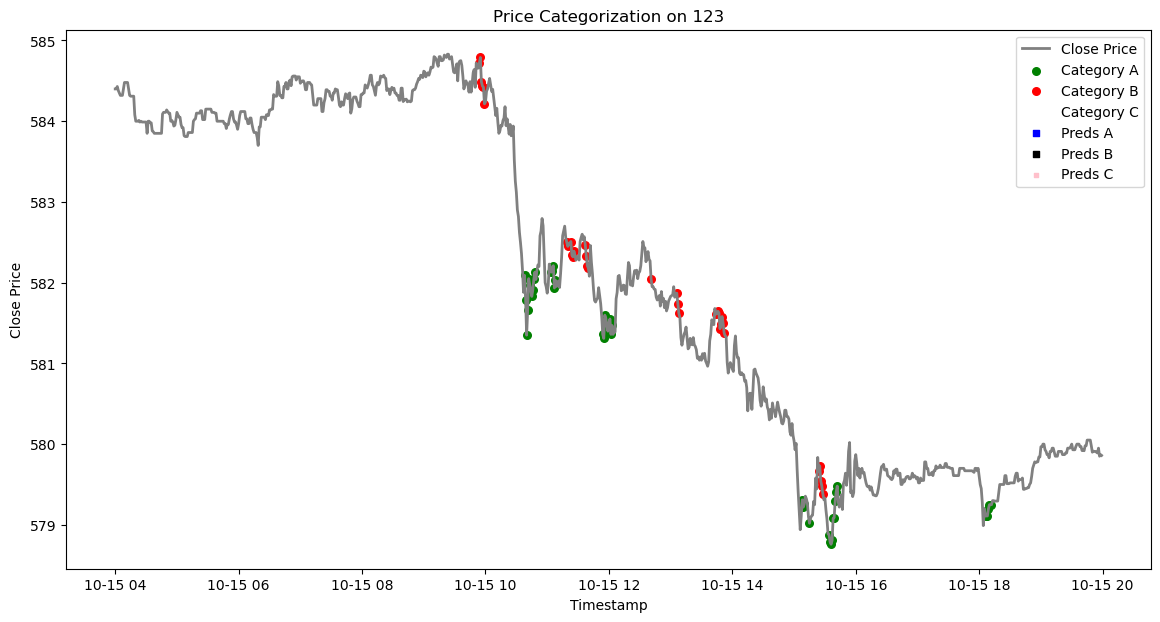

In [34]:
field = 'close'
df_day = df.loc['2024-10-15']
df_day['preds'] = list(preds_probs1)
plt.figure(figsize=(14, 7))
plt.plot(df_day.index, df_day[field], label=f'{field.capitalize()} Price', color='gray', linewidth=2)
# plt.plot(df_day.index, df_day['close'], label=f'{field.capitalize()} Price', color='blue', linewidth=1)
for cat, color in zip(['A', 'B', 'C'], ['green', 'red', 'gray']):
    plt.scatter(df_day[df_day['category'] == cat].index, df_day[df_day['category'] == cat][field], color=color, label=f'Category {cat}', s=30 if cat!='C' else 0)
for cat, color in zip(['A', 'B', 'C'], ['blue', 'black', 'pink']):
    # print(cat)
    # print(df_day[df_day['preds'] == cat].index)
    plt.scatter(df_day[df_day['preds'] == cat].index, df_day[df_day['preds'] == cat][field], color=color, label=f'Preds {cat}', s=20 if cat!='C' else 10, 
                # marker = '1' if cat=='B' else '2' if cat=='A' else '+')
                marker='s')
plt.legend()
plt.title(f'Price Categorization on {123}')
plt.xlabel('Timestamp')
plt.ylabel(f'{field.capitalize()} Price')
# plt.show()
plt.savefig(f'plot for day - {123}.png')
# log(None, dt, image=1, add=f'plot for day - {123}.png')
# log("\n\n", date)